Name: Saleh Abdallah

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import warnings
warnings.filterwarnings('ignore')

Data Collection

In [67]:
# Historical Sstocks dataset
df_info = pd.read_csv('historical_stocks.csv')
df_info.head()

,ticker,exchange,name,sector,industry
0,PIH,NASDAQ,"1347 PROPERTY INSURANCE HOLDINGS, INC.",FINANCE,PROPERTY-CASUALTY INSURERS
1,PIHPP,NASDAQ,"1347 PROPERTY INSURANCE HOLDINGS, INC.",FINANCE,PROPERTY-CASUALTY INSURERS
2,TURN,NASDAQ,180 DEGREE CAPITAL CORP.,FINANCE,FINANCE/INVESTORS SERVICES
3,FLWS,NASDAQ,"1-800 FLOWERS.COM, INC.",CONSUMER SERVICES,OTHER SPECIALTY STORES
4,FCCY,NASDAQ,1ST CONSTITUTION BANCORP (NJ),FINANCE,SAVINGS INSTITUTIONS


In [86]:
# Historical Sstock Prices dataset
df_prices = pd.read_csv('historical_stock_prices.csv')
df_prices.head()

,ticker,open,close,adj_close,low,high,volume,date
0,AHH,11.50,11.58,8.493155,11.25,11.68,4633900,2013-05-08
1,AHH,11.66,11.55,8.471151,11.50,11.66,275800,2013-05-09
2,AHH,11.55,11.60,8.507822,11.50,11.60,277100,2013-05-10
3,AHH,11.63,11.65,8.544494,11.55,11.65,147400,2013-05-13
4,AHH,11.60,11.53,8.456484,11.50,11.60,184100,2013-05-14


Data Cleaning

In [ ]:
# Check missing values in df_info
df_info.isnull().sum()

ticker         0
exchange       0
name           0
sector      1440
industry    1440
dtype: int64

In [ ]:
# Handle missing values in df_info
df_info.dropna(subset=['sector', 'industry'], inplace=True)
print(f'Total null values in df_info is:', df_info.isnull().sum().sum())

Total null values in df_info is: 0


In [ ]:
# Merge df_info and df_prices
df = pd.merge(df_info, df_prices.reset_index(), how='inner', on='ticker')
# Set the date back as index
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date', drop=True)
if 'index' in df.columns:
    df = df.drop(columns='index')
df.head()

,ticker,exchange,name,sector,industry,open,close,adj_close,low,high,volume
date,,,,,,,,,,,
2014-04-01,PIH,NASDAQ,"1347 PROPERTY INSURANCE HOLDINGS, INC.",FINANCE,PROPERTY-CASUALTY INSURERS,8.00,7.95,7.95,7.90,8.50,642900
2014-04-02,PIH,NASDAQ,"1347 PROPERTY INSURANCE HOLDINGS, INC.",FINANCE,PROPERTY-CASUALTY INSURERS,7.94,8.16,8.16,7.90,8.29,228400
2014-04-03,PIH,NASDAQ,"1347 PROPERTY INSURANCE HOLDINGS, INC.",FINANCE,PROPERTY-CASUALTY INSURERS,8.29,8.39,8.39,8.05,8.40,105000
2014-04-04,PIH,NASDAQ,"1347 PROPERTY INSURANCE HOLDINGS, INC.",FINANCE,PROPERTY-CASUALTY INSURERS,8.50,8.69,8.69,8.32,8.70,113600
2014-04-07,PIH,NASDAQ,"1347 PROPERTY INSURANCE HOLDINGS, INC.",FINANCE,PROPERTY-CASUALTY INSURERS,9.00,8.94,8.94,8.55,9.00,60500


Advanced Data Cleaning

In [ ]:
# Handle Outliers - Capping
df_capped = df.copy()

# Check outliers across the df
for i in df_capped.select_dtypes(include='number').columns:
    lower = df_capped[i].quantile(0.1)
    upper = df_capped[i].quantile(0.9)
    df_capped[i] = df_capped[i].clip(lower, upper)

# Final shape before and after 
print(f'\nOriginal DF shape: {df.shape}')
print(f'Revised DF shape: {df_capped.shape}')
print(f'Total removed rows: {df.shape[0] - df_capped.shape[0]}')


Original DF shape: (18424440, 11)
Revised DF shape: (18424440, 11)
Total removed rows: 0


Data Transformation

In [ ]:
# Feature Engineering
# 30-day rolling average for the 'close' price
df_capped['close_rolling_avg'] =df_capped['close'].rolling(window=30).mean().round(2)
# Volatility for the 'close' price
df_capped['close_volatility'] =df_capped['close'].rolling(window=30).std().round(2)

In [ ]:
# Scaling 'volume'
scaler = StandardScaler()
df_capped['volume'] = scaler.fit_transform(df_capped[['volume']])

Feature Engineering with Technical Indicators

In [ ]:
# EMA function
def EMA(data, period=12, column='close'):
    return data[column].ewm(span=period, adjust=False).mean()

In [ ]:
# Calculate MACD & Signal Line
df_capped['EMA12'] = EMA(df_capped, period=12).round(2)
df_capped['EMA26'] = EMA(df_capped, period=26).round(2)
df_capped['MACD'] = df_capped['EMA12'] - df_capped['EMA26']
df_capped['Signal_Line'] = EMA(df_capped, period=9, column='MACD').round(2)

In [ ]:
# RSI function
def RSI(data, period=14):
    delta = data['close'].diff()
    gain = delta.where(delta > 0, 0).ewm(span=period, adjust=False).mean()
    loss = -delta.where(delta < 0, 0).ewm(span=period, adjust=False).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

In [ ]:
# Calculate RSI
df_capped['RSI'] = RSI(df_capped)

In [ ]:
# Signal generation
df_capped['Buy_Signal_MACD'] = df_capped['MACD'] > df_capped['Signal_Line']
df_capped['Sell_Signal_MACD'] = df_capped['MACD'] < df_capped['Signal_Line']
df_capped['Buy_Signal_RSI'] = df_capped['RSI'] < 30
df_capped['Sell_Signal_RSI'] = df_capped['RSI'] > 70

df_capped['Signal'] = np.where(df_capped['Buy_Signal_MACD'] & df_capped['Buy_Signal_RSI'], 'Buy',
                   np.where(df_capped['Sell_Signal_MACD'] & df_capped['Sell_Signal_RSI'], 'Sell', 'Hold'))
df_capped.fillna(0, inplace=True)

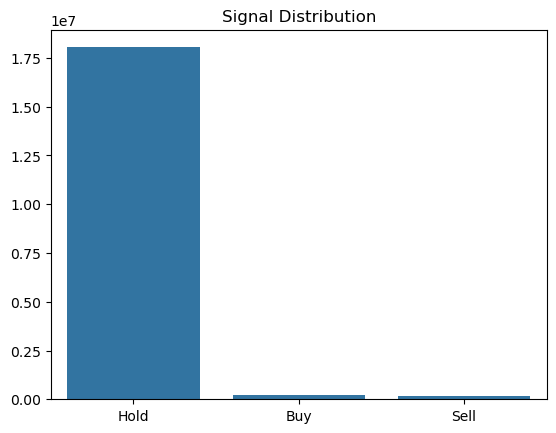

In [ ]:
# Target variable distribution
sns.countplot(x='Signal', data=df_capped)
plt.title('Signal Distribution')
plt.xlabel('')
plt.ylabel('')
plt.show()

Data Preparation and Splitting

In [ ]:
features = ['RSI', 'MACD', 'volume', 'close_rolling_avg', 'close_volatility']
# Very Large dataset - system crashed
# Using sample of the data - 1%
df_sample = df_capped.sample(frac=0.01, random_state=42) 
X_train, X_test, y_train, y_test = train_test_split(df_sample[features], df_sample['Signal'], test_size=0.2, random_state=42)

In [ ]:
# Resampling the imbalanced data
smote_tomek = SMOTETomek(random_state=42)
X_smote_tomek, y_smote_tomek = smote_tomek.fit_resample(X_train, y_train)

In [ ]:
# Target variable distribution count after resampling
y_smote_tomek.value_counts()

Signal
Sell    144278
Buy     144242
Hold    144169
Name: count, dtype: int64


In [ ]:
# Target variable distribution percentage after resampling
y_smote_tomek.value_counts(normalize=True)*100

Signal
Sell    33.344504
Buy     33.336184
Hold    33.319312
Name: proportion, dtype: float64


Model Building and Optimization

In [ ]:
# Logistic Regression, Random Forest & SVM
classification_models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest Classifier': RandomForestClassifier(),
    'SVM Classifier': LinearSVC()
}

In [72]:
# Logistic Regression
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

# Random Forest Parameters
rf_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10],
    'class_weight': ['balanced']
}

# Linear SVM
svm_param_grid = {
    'C': [0.1, 1, 10],
    'class_weight': ['balanced']
}

In [77]:
# Logistic Regression
lr_grid = GridSearchCV(
    LogisticRegression(),
    lr_param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1
)

# Random Forest
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1
)

# Linear SVM
svm_grid = GridSearchCV(
    estimator=LinearSVC(max_iter=10000),
    param_grid=svm_param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1
)

Model Training & Hyperparameter Tuning

In [80]:
# Logistic Regression
lr_grid.fit(X_smote_tomek, y_smote_tomek)

GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10], 'penalty': ['l2'],
                         'solver': ['lbfgs']},
             scoring='f1')

In [81]:
# Random Forest
rf_grid.fit(X_smote_tomek, y_smote_tomek)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'max_depth': [10],
                         'n_estimators': [50, 100]},
             scoring='f1')

In [82]:
# Linear SVM
svm_grid.fit(X_smote_tomek, y_smote_tomek)

GridSearchCV(cv=3, estimator=LinearSVC(max_iter=10000), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'class_weight': ['balanced']},
             scoring='f1')

In [83]:
# Logistic Regression best parameters
best_lr = lr_grid.best_estimator_
# Random Forest best parameters
best_rf = rf_grid.best_estimator_
# Linear SVM best parameters
best_svm = svm_grid.best_estimator_

print("Best LR Params:", lr_grid.best_params_)
print("Best RF Params:", rf_grid.best_params_)
print("Best SVM Params:", svm_grid.best_params_)

Best LR Params: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Best RF Params: {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 50}
Best SVM Params: {'C': 0.1, 'class_weight': 'balanced'}


Model Evaluation

In [84]:
# Logistic Regression predictions
lr_pred = best_lr.predict(X_test)
# Random Forest predictions
rf_pred = best_rf.predict(X_test)
# Linear SVM predictions
svm_pred = best_svm.predict(X_test)

print("Logistic Regression Report:\n", classification_report(y_test, lr_pred))
print("Random Forest Report:\n", classification_report(y_test, rf_pred))
print("Linear SVM Report:\n", classification_report(y_test, svm_pred))

Logistic Regression Report:
               precision    recall  f1-score   support

         Buy       0.08      0.96      0.15       390
        Hold       1.00      0.70      0.83     36092
        Sell       0.05      0.92      0.10       367

    accuracy                           0.71     36849
   macro avg       0.38      0.86      0.36     36849
weighted avg       0.98      0.71      0.81     36849

Random Forest Report:
               precision    recall  f1-score   support

         Buy       0.18      0.93      0.29       390
        Hold       1.00      0.88      0.93     36092
        Sell       0.11      0.95      0.20       367

    accuracy                           0.88     36849
   macro avg       0.43      0.92      0.48     36849
weighted avg       0.98      0.88      0.92     36849

Linear SVM Report:
               precision    recall  f1-score   support

         Buy       0.05      1.00      0.10       390
        Hold       1.00      0.58      0.73     36092
   

Reporting and Documentation

1. Feature Engineering:

    * MACD, Signal Line, RSI
    * Generated trading signals: 'Buy', 'Sell', 'Hold'

2. Data Sampling and Splitting

    * Due to the huge dataset size, a 1% random sample was used.
    * SMOTETomek resampling was applied on the training set to handle the 'signal' imbalance.

3. Model Training & Hyperparameter Tuning

    The below models were trained using GridSearchCV with 3-fold cross-validation:

    * Logistic Regression
    * Random Forest
    * Linear SVM

4. Classification Report Summary

    Random Forest perfomed the best compared to the other models over all metrics, especially in classifying 'Buy' and 'Sell' although its precision for Buy/Sell was somehow low.